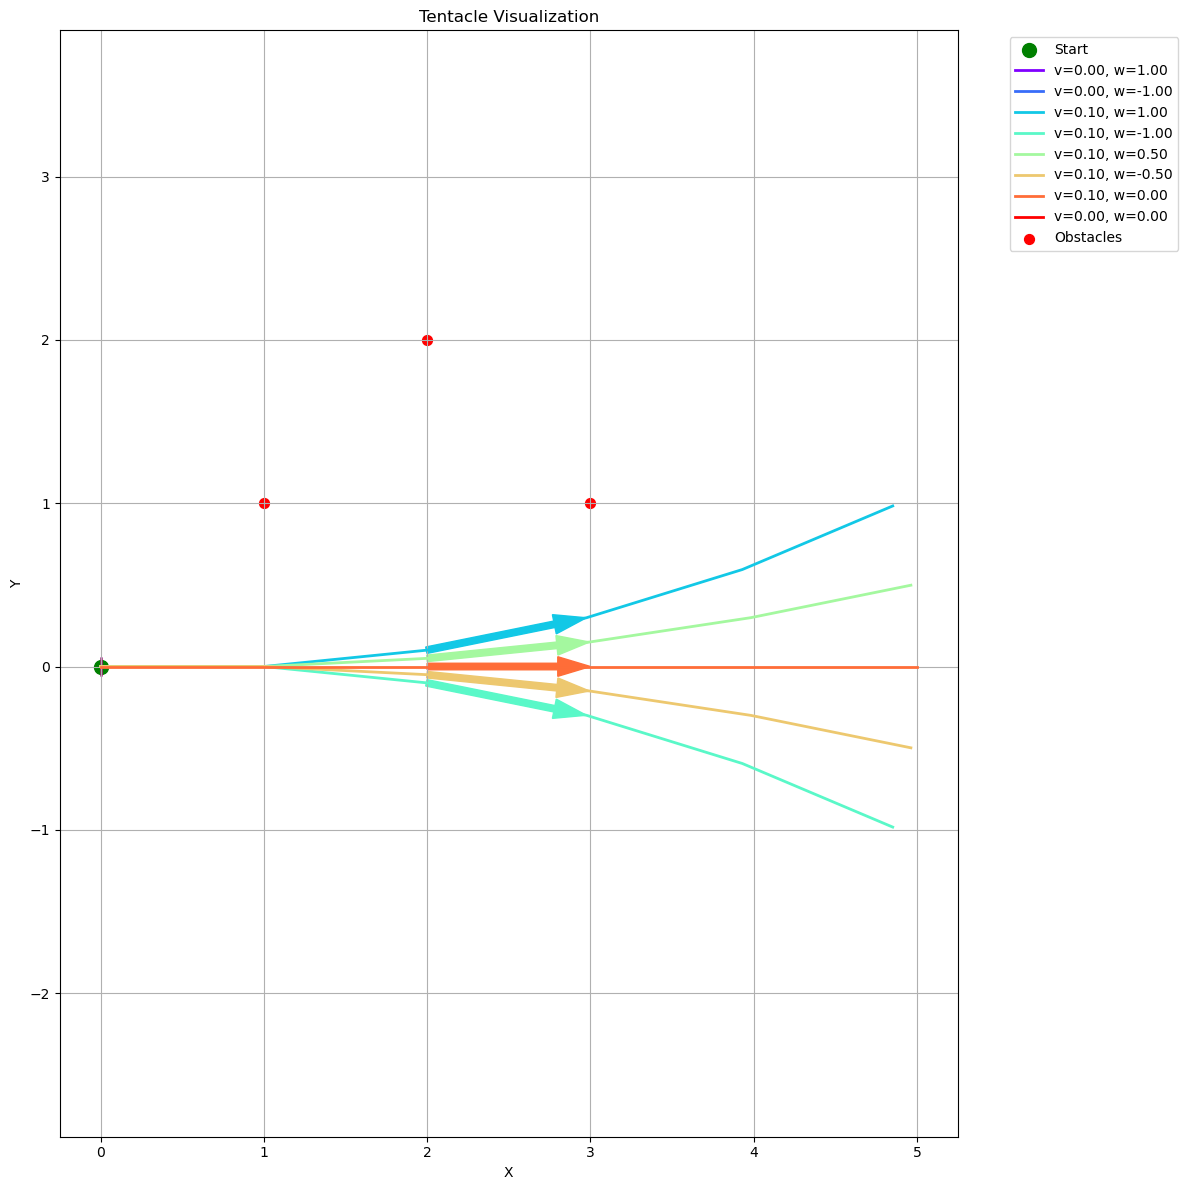

eheheheheeh


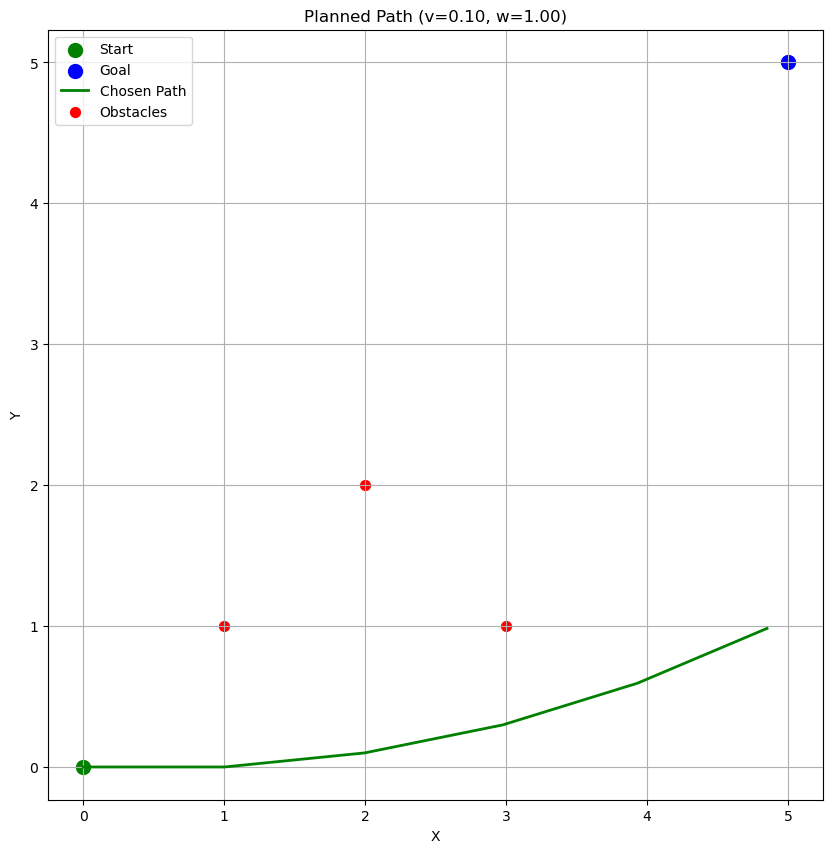

In [1]:
from tentacle_planner import TentaclePlanner
import numpy as np
# Create a TentaclePlanner instance
obstacles = np.array([[1, 1], [2, 2], [3, 1]])  # Example obstacles
planner = TentaclePlanner(obstacles)

# Visualize all tentacles from a starting position
planner.visualize_tentacles(0, 0, 0)

# Visualize the planned path to a goal
planner.visualize_plan(5, 5, np.pi / 4, 0, 0, 0)